<img src="..//Deteccion_fuego/images/immune.jpeg"  width="30%" height="15%">

# 03 - Creación y entrenamiento de una red neuronal con Tensorflow


![tensorflow](..//Deteccion_fuego/images/tensorflow.jpeg)

### Primero un poco de teoría

![node](..//Deteccion_fuego/images/node.png)


![neural](..//Deteccion_fuego/images/neural.jpg)

### Convolucionales

https://en.wikipedia.org/wiki/Convolution


![neural2](..//Deteccion_fuego/images/neural2.webp)

![neural3](..//Deteccion_fuego/images/neural3.gif)

![neural4](..//Deteccion_fuego/images/neural4.png)


https://towardsdatascience.com/a-comprehensible-explanation-of-the-dimensions-in-cnns-841dba49df5e

# Entrenamiento del modelo (ajuste)

In [1]:
#%pip install tensorflow

In [2]:
#%pip install keras

In [3]:
#%pip install imutils

In [4]:
#%pip install visualkeras

In [5]:
#%pip install opencv-python

In [6]:
#%pip install pandas

In [7]:
#%pip install scikit-learn

In [8]:
# librerias
import warnings
warnings.filterwarnings('ignore')

import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input

from keras.models import Model

from keras.optimizers.legacy import Adam


from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical


from imutils import paths
import visualkeras
from IPython.display import Image

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report as report
import datetime

**Cargando y preparando datos**

In [9]:
imagenes=list(paths.list_images(f'..//Deteccion_fuego/data/dataset_fuego'))

In [10]:
imagenes[0]

'..//Deteccion_fuego/data/dataset_fuego\\con_fuego\\1.jpg'

In [11]:
Image(url=imagenes[0], width=300)

In [12]:
# preparando datos

data=[]
etiquetas=[]

for img in imagenes:
    
    # etiqueta segun nombre del archivo
    if 'con_' in img:
        etiquetas.append([0])  # con tema
    else:
        etiquetas.append([1])  # sin tema
    
    
    # carga la imagen (224x224) y procesala
    imagen=load_img(img, target_size=(224, 224))
    imagen=img_to_array(imagen)
    imagen=preprocess_input(imagen)

    # añade a la lista
    data.append(imagen)
    

    
# se convierten datos y etiquetas a arrays de numpy
data=np.array(data, dtype='float32')
etiquetas=np.array(etiquetas)

In [13]:
data[0].shape

(224, 224, 3)

In [14]:
etiquetas[0]

array([0])

In [15]:
# one hot para las etiquetas

etiquetas=to_categorical(etiquetas)

etiquetas[0]

array([1., 0.])

In [16]:
# train-test split (separa datos de entrenamiento y testeo)

X_train, X_test, y_train, y_test=tts(data, 
                                     etiquetas, 
                                     test_size=.2, 
                                     stratify=etiquetas, 
                                     random_state=42)

In [17]:
X_train.shape

(2420, 224, 224, 3)

In [18]:
# aumenta datos con el generador de imagenes
# Crea nuevas imagenes rotando, transponiendo, haciendo zoom, etc.

img_gen=ImageDataGenerator(rotation_range=20, 
                           zoom_range=.15,
                           width_shift_range=.2, 
                           height_shift_range=.2,
                           shear_range=.15, 
                           horizontal_flip=True,
                           fill_mode='nearest')

## Modelo - Red Neuronal

Se creara el modelo con MobileNetV2, una red para reconocimiento de imagenes preentrenada.

**constantes**

In [19]:
TASA=1e-4    # tasa de aprendizaje

EPOCAS=5     # epocas de entrenamiento

BATCH=32     # tamaño del batch (muestra de datos que pasan a la red para entrenar)

**Red**

In [20]:
# se carga MobileNetV2 sin el clasificador
modelo_base=MobileNetV2(weights='imagenet', 
                        include_top=False, # LA ÚLTIMA CAPA LA PONGO YO
                        input_tensor=Input(shape=(224, 224, 3))) # UN CUBO DE 3 CAPAS DE 224, POR 224  PIXELES


# se contruye el nuevo clasificador
modelo_x=modelo_base.output

modelo_x=AveragePooling2D(pool_size=(7, 7))(modelo_x)

modelo_x=Flatten(name='flatten')(modelo_x)

modelo_x=Dense(128, activation='relu')(modelo_x)

modelo_x=Dropout(.5)(modelo_x) # Desconectamos capas para quitar el overfitting (aprender de memoria). Corta conexiones. Las conexiones que existen, se vuelven más eficientes.

modelo_x=Dense(2, activation='softmax')(modelo_x)



# se pone todo junto
modelo=Model(inputs=modelo_base.input, outputs=modelo_x)

In [21]:
# se congela el entrenamiento del modelo base, aprovechamos el preentreno
# Esas capas, los pesos que ya tienen déjalos como están, no los toques

for capa in modelo_base.layers:
    capa.trainable=False

In [22]:
# se compila el modelo
from tensorflow.keras.optimizers import Adam

optimizador = Adam(learning_rate=TASA)
modelo.compile(loss='binary_crossentropy', 
               optimizer=optimizador, 
               metrics=['accuracy'])


In [23]:
modelo.summary() # resumen de la red

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

EL AVERAGE PULLING Y LAS 5 ÚLTIMAS CAPAS SON LAS QUE SE HAN AÑADIDO MANUALMENTE A LA RED

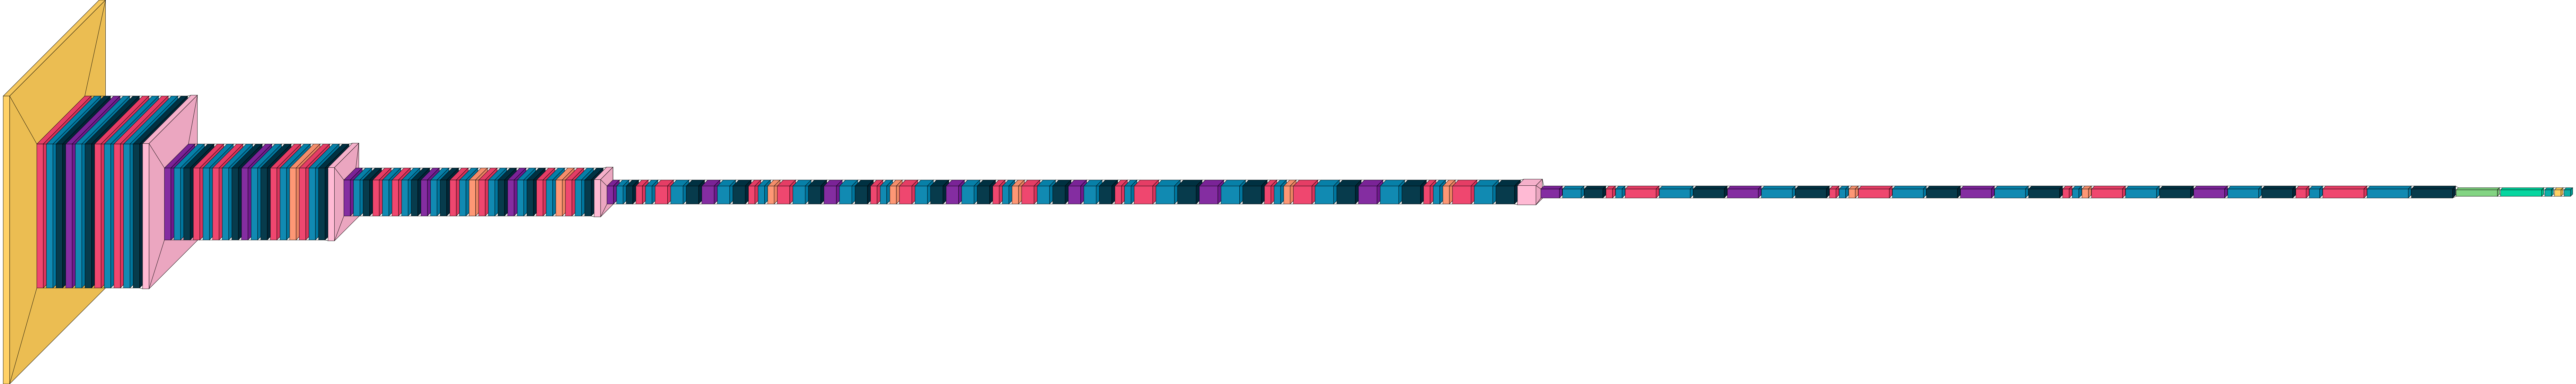

In [24]:
visualkeras.layered_view(modelo)

In [25]:
%%time

# se entrena el clasificador con las imagenes
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    return lr * (1 / (1 + TASA / EPOCAS * epoch))

callback = LearningRateScheduler(scheduler)

print('Entrenando modelo...')

historico=modelo.fit(img_gen.flow(X_train, y_train, batch_size=BATCH), 
                     steps_per_epoch=len(X_train)//BATCH,
                     validation_data=(X_test, y_test), 
                     validation_steps=len(X_test)//BATCH, 
                     epochs=EPOCAS,
                     callbacks=[callback])

print('Entrenado.')

Entrenando modelo...
Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 254ms/step - accuracy: 0.8053 - loss: 0.5111 - val_accuracy: 0.9521 - val_loss: 0.1925 - learning_rate: 1.0000e-04
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 1.0000 - loss: 0.1296 - val_accuracy: 0.9521 - val_loss: 0.1906 - learning_rate: 9.9998e-05
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 252ms/step - accuracy: 0.9407 - loss: 0.2120 - val_accuracy: 0.9587 - val_loss: 0.1373 - learning_rate: 9.9994e-05
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9375 - loss: 0.1565 - val_accuracy: 0.9587 - val_loss: 0.1374 - learning_rate: 9.9988e-05
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 259ms/step - accuracy: 0.9518 - loss: 0.1527 - val_accuracy: 0.9752 - val_loss: 0.0884 - learning_rate: 9.9980e-05
Entrenado.
CPU times: total: 29 s
Wall time: 1min 5s


In [26]:
#%%time

# se entrena el clasificador con las imagenes

#print('Entrenando modelo...')

#historico=modelo.fit(img_gen.flow(X_train, y_train, batch_size=BATCH), 
#                     steps_per_epoch=len(X_train)//BATCH,
#                     validation_data=(X_test, y_test), 
#                     validation_steps=len(X_test)//BATCH, 
#                     epochs=EPOCAS)

#print('Entrenado.')

In [27]:
# haciendo predicciones
preds=modelo.predict(X_test, batch_size=BATCH)

preds[0]  # en probabilidad

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step


array([9.9999976e-01, 1.9835532e-07], dtype=float32)

In [28]:
# la mayor prob de pertenencia, en 0/1
# Hay que coger el argumento máximo, dame el número que es el elemento máximo dentro del array
preds=np.argmax(preds, axis=1)

preds[0]  

np.int64(0)

In [29]:
# informe de clasificacion

print(report(y_test.argmax(axis=1), preds, target_names=['con_', 'sin_']))

              precision    recall  f1-score   support

        con_       0.97      0.99      0.98       354
        sin_       0.99      0.95      0.97       252

    accuracy                           0.98       606
   macro avg       0.98      0.97      0.97       606
weighted avg       0.98      0.98      0.98       606



In [30]:
# guardando modelo en formato h5

modelo.save(f'..//Deteccion_fuego/model/fuego.h5')
